In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

In [3]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [4]:
import matplotlib.pyplot as plt

In [5]:
import variant_orbits
import scheduling
import detection_probability
import magnitudes
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [6]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

In [32]:
night_start = 10
path = "../neocp/neo/"
detection_window = 15
min_nights = 3
schedule_type = "predicted"

# create a list of nights in the detection window and get schedule for them
night_list = list(range(night_start, night_start + detection_window))

if schedule_type == "predicted":
    full_schedule = scheduling.get_LSST_schedule(night=night_start, schedule_type=schedule_type)
else:
    full_schedule = scheduling.get_LSST_schedule(night=(night_start, night_start + detection_window - 1),
                                                 schedule_type=schedule_type)

# offset the schedule by one row and re-merge to get the previous night column
shifted = full_schedule.shift()
full_schedule["previousNight"] = shifted["night"]

# calculate the length of each night in days
night_lengths = np.zeros(detection_window)
for i, night in enumerate(night_list):
    mask = full_schedule["night"] == night

    # ignore nights that have no observations (bad weather/downtime)
    if not full_schedule[mask].empty:
        night_lengths[i] = full_schedule[mask].iloc[-1]["observationStartMJD"]\
            - full_schedule[mask].iloc[0]["observationStartMJD"]

# get the first/last visit from each night
night_transition = full_schedule["night"] != full_schedule["previousNight"]
first_visit_times = full_schedule[night_transition]["observationStartMJD"].values

last_times_ind = np.array(list(full_schedule[night_transition].index[1:]) + [len(full_schedule)]) - 1
last_visit_times = full_schedule.loc[last_times_ind]["observationStartMJD"].values

file = 0
visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")

# get the objects from the night
obs_mask = np.logical_and(visit_file["night"] == night_start, visit_file["scores"] >= 65)
sorted_obs = visit_file[obs_mask].sort_values(["ObjID", "FieldMJD"])
unique_objs = sorted_obs.index.unique()

# Main run

In [146]:
%%time
obj_pos = SkyCoord(ra=joined_table["RA_deg"], dec=joined_table["Dec_deg"], unit="degree", frame="icrs")
field_pos = SkyCoord(ra=joined_table["fieldRA"], dec=joined_table["fieldDec"], unit="degree", frame="icrs")

CPU times: user 31.9 s, sys: 1.48 s, total: 33.4 s
Wall time: 33.5 s


In [147]:
observed_reality = obj_pos.separation(field_pos) <= 2.1 * u.deg

In [162]:
%%time
in_current_field = np.repeat(False, len(joined_table))
bright_table = joined_table[bright_enough]
obj_pos = SkyCoord(ra=bright_table["RA_deg"], dec=bright_table["Dec_deg"], unit="degree", frame="icrs")
sch_pos = SkyCoord(ra=bright_table["fieldRA"], dec=bright_table["fieldDec"], unit="degree", frame="icrs")
in_current_field[bright_enough] = obj_pos.separation(sch_pos) <= 2.1 * u.deg

CPU times: user 14 s, sys: 486 ms, total: 14.5 s
Wall time: 14.5 s


In [144]:
observed_reality_fast = obj_pos_fast.separation(field_pos_fast) <= 2.1 * u.deg

In [ ]:
joined_table

In [159]:
x = np.isin(joined_table.index, joined_table[bright_enough][observed_reality_fast].index) == joined_table["observed"]

In [145]:
joined_table[bright_enough][observed_reality_fast]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,night,previousNight,mag_in_filter,observed
16654,0,I11,59649.263903,167.281587,-27.448586,-0.607249,0.390639,28.717468,148.510342,1.079843,0.099985,23.047280,302.752867,180.271577,-30.041783,9.917822,-30.040579,171.145615,-2.657977,0.791859,-2.656773,67.484168,-50.345863,-24.796645,0.569975,93.219003,-1.065826,0.166035,-0.050076,0.046740,-0.015745,0.029076,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,10,10.0,22.867280,True
16655,1,I11,59649.263903,167.280764,-27.447434,-0.599726,0.392603,28.472382,148.511391,1.088318,0.109636,23.047409,303.210250,180.270227,-30.041080,9.916471,-30.039877,171.215352,-2.891862,0.861597,-2.890658,67.483206,-50.345863,-27.486978,0.485603,119.198473,-1.074181,0.165997,-0.054907,0.046729,-0.015637,0.029095,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,10,10.0,22.867409,True
16656,2,I11,59649.263903,167.279978,-27.446295,-0.588105,0.388564,28.208105,148.512431,1.097632,0.120218,23.047531,303.452946,180.268917,-30.040374,9.915161,-30.039171,171.290603,-3.144144,0.936848,-3.142941,67.482279,-50.345863,-27.486978,0.485603,119.197482,-1.083342,0.165957,-0.060203,0.046719,-0.015532,0.029111,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,10,10.0,22.867531,True
16657,3,I11,59649.263903,167.279301,-27.445300,-0.579521,0.388813,27.923653,148.513340,1.107872,0.131821,23.047647,303.858512,180.267781,-30.039755,9.914025,-30.038551,171.371705,-3.415881,1.017950,-3.414677,67.481476,-50.345863,-27.486978,0.485603,119.196615,-1.093387,0.165912,-0.066010,0.046706,-0.015409,0.029133,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,10,10.0,22.867647,True
16658,4,I11,59649.263903,167.278624,-27.444360,-0.568951,0.386244,27.617874,148.514196,1.119130,0.144543,23.047759,304.171417,180.266674,-30.039183,9.912918,-30.037980,171.458967,-3.708102,1.105212,-3.706898,67.480686,-50.345863,-27.486978,0.485603,119.195802,-1.104401,0.165863,-0.072378,0.046693,-0.015283,0.029155,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,10,10.0,22.867759,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372706,370,I11,59662.182754,150.636396,-10.711060,-2.984787,3.590653,29.906703,146.554027,1.101964,0.123428,20.748169,320.264410,156.738327,-21.233619,-26.469219,-21.232984,180.538175,-2.325456,-2.669372,-2.324821,59.273216,-60.654510,31.175937,0.506062,75.519929,-1.101008,-0.010342,-0.044713,0.014175,-0.013636,0.009469,-0.995312,-0.055778,-0.000011,270.021697,11018,151.998054,-11.723639,59662.182754,i,23.538603,23,23.0,20.458169,True
372707,371,I11,59662.182754,152.701481,-13.100620,-2.276383,2.715352,27.995109,147.807522,1.131453,0.155441,21.019214,320.025614,159.728499,-22.683560,-23.479047,-22.682925,180.308741,-3.037523,-2.898805,-3.036888,62.373478,-60.654510,31.175937,0.506062,73.312393,-1.129847,-0.006088,-0.059956,0.014014,-0.013296,0.009537,-0.995312,-0.055778,-0.000011,268.622751,11018,151.998054,-11.723639,59662.182754,i,23.538603,23,23.0,20.729214,True
372736,417,I11,59662.182754,151.682530,-11.538760,-2.660000,3.227607,30.050700,147.329244,1.074600,0.091000,20.938852,320.506704,158.093654,-21.616941,-25.113892,-21.616306,181.291825,-1.788340,-1.915722,-1.787705,60.589159,-60.654510,31.175937,0.506062,74.782290,-1.073803,-0.024215,-0.033535,0.009568,-0.014737,0.006363,-0.995312

In [142]:
len(observed_reality)

163147

In [136]:
bright_enough = joined_table["mag_in_filter"] < joined_table["fiveSigmaDepth"]

In [107]:
matches = joined_table["observed"] == np.logical_and(observed_reality, bright_enough)

In [ ]:
np.lins

In [113]:
joined_table[np.logical_not(matches)]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,night,previousNight,mag_in_filter,observed
17365,0,I11,59649.264364,167.281244,-27.448416,-0.606618,0.391538,28.717907,148.510602,1.079820,0.099958,23.046668,302.840021,180.271175,-30.041767,9.916954,-30.040566,171.145818,-2.657323,0.791597,-2.656122,67.339772,-50.262626,-24.928220,0.570023,93.213189,-1.065805,0.166027,-0.050063,0.046740,-0.015746,0.029077,-0.979276,0.166437,-0.000021,-5672.282172,119,168.541675,-25.723590,59649.264364,r,24.466772,10,10.0,22.866668,False
17366,1,I11,59649.264364,167.280409,-27.447234,-0.595059,0.395712,28.472787,148.511679,1.088295,0.109609,23.046848,303.623745,180.269798,-30.041042,9.915577,-30.039841,171.215550,-2.891215,0.861329,-2.890014,67.338793,-50.262626,-27.460696,0.485606,119.198081,-1.074160,0.165990,-0.054893,0.046724,-0.015643,0.029103,-0.979276,0.166437,-0.000021,-5672.282172,119,168.541675,-25.723590,59649.264364,r,24.466772,10,10.0,22.866848,False
17367,2,I11,59649.264364,167.279662,-27.446130,-0.588589,0.388779,28.208529,148.512689,1.097609,0.120191,23.047017,303.445879,180.268541,-30.040353,9.914320,-30.039152,171.290803,-3.143510,0.936581,-3.142309,67.337907,-50.262626,-27.460696,0.485606,119.197118,-1.083321,0.165949,-0.060190,0.046720,-0.015532,0.029110,-0.979276,0.166437,-0.000021,-5672.282172,119,168.541675,-25.723590,59649.264364,r,24.466772,10,10.0,22.867017,False
17368,3,I11,59649.264364,167.278985,-27.445080,-0.580894,0.390163,27.924017,148.513653,1.107849,0.131794,23.047175,303.887671,180.267377,-30.039683,9.913156,-30.038482,171.371899,-3.415252,1.017677,-3.414051,67.337093,-50.262626,-27.460696,0.485606,119.196197,-1.093366,0.165905,-0.065997,0.046706,-0.015405,0.029134,-0.979276,0.166437,-0.000021,-5672.282172,119,168.541675,-25.723590,59649.264364,r,24.466772,10,10.0,22.867175,False
17369,4,I11,59649.264364,167.278283,-27.444208,-0.568662,0.388861,27.618291,148.514438,1.119107,0.144516,23.047326,304.365012,180.266282,-30.039184,9.912061,-30.037982,171.459157,-3.707494,1.104936,-3.706293,67.336296,-50.262626,-27.460696,0.485606,119.195455,-1.104380,0.165856,-0.072365,0.046690,-0.015281,0.029160,-0.979276,0.166437,-0.000021,-5672.282172,119,168.541675,-25.723590,59649.264364,r,24.466772,10,10.0,22.867326,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357412,424,I11,59662.156229,158.066396,-18.841617,-0.885298,1.048941,23.168877,149.962152,1.268298,0.303028,22.101294,319.835899,167.422068,-25.907812,-15.758858,-25.907036,179.816380,-5.992762,-3.364546,-5.991985,76.335211,-57.487240,32.189262,0.506548,68.040166,-1.261361,0.004042,-0.132414,0.008537,-0.012510,0.006814,-0.995329,-0.055315,-0.000014,251.406290,10963,156.263909,-17.720890,59662.156229,r,24.029583,23,23.0,21.921294,False
358003,177,I11,59662.156677,153.427469,-15.042611,-1.985882,2.166186,22.738846,147.793093,1.374552,0.424240,20.962859,317.486522,161.254649,-24.202401,-21.926727,-24.201627,177.098113,-7.269683,-6.083263,-7.268909,70.564001,-57.559239,32.172648,0.506540,71.417963,-1.361754,0.069028,-0.173935,0.032392,-0.007329,0.022059,-0.995329,-0.055323,-0.000013,-5672.282172,10964,155.587597,-14.954411,59662.156677,r,24.009745,23,23.0,20.782859,False
367819,178,I11,59662.180463,154.664518,-16.303268,-1.640886,1.774831,21.030424,148.352985,1.457501,0.511782,21.172292,317.245664,163.003527,-24.893206,-20.201719,-24.892559,176.820013,-8.500094,-6.385233,-8.499446,66.502344,-60.477224,31.265531,0.506103,70.290058,-1.439271,0.079963,-0.215435,0.032146,-0.006438,0.022215,-0.

In [95]:
joined_table

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,night,previousNight,mag_in_filter,observed
0,0,I11,59649.207792,167.319001,-27.469205,-0.581224,0.345877,28.664604,148.478125,1.082645,0.103224,23.120600,300.756215,180.316537,-30.045332,10.019493,-30.043830,171.120738,-2.737564,0.823695,-2.736062,84.733972,-56.172855,-9.149770,0.564573,93.884893,-1.068449,0.166919,-0.051709,0.046726,-0.015744,0.029077,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.830600,False
1,1,I11,59649.207792,167.317530,-27.468367,-0.572479,0.353569,28.420905,148.478793,1.091123,0.112874,23.114726,301.699907,180.314755,-30.045167,10.017712,-30.043666,171.190781,-2.970309,0.893737,-2.968808,84.732423,-56.172855,-30.808605,0.485264,119.241819,-1.076803,0.166875,-0.056540,0.046711,-0.015641,0.029102,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.824726,False
2,2,I11,59649.207792,167.316452,-27.466986,-0.568270,0.350473,28.157549,148.480043,1.100443,0.123456,23.109342,301.663609,180.313053,-30.044362,10.016009,-30.042860,171.266372,-3.221312,0.969328,-3.219810,84.730913,-56.172855,-30.808605,0.485264,119.240638,-1.085964,0.166828,-0.061837,0.046706,-0.015530,0.029109,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.819342,False
3,3,I11,59649.207792,167.315361,-27.466108,-0.562683,0.354954,27.874426,148.480792,1.110687,0.135059,23.104433,302.244713,180.311598,-30.044012,10.014555,-30.042510,171.347845,-3.491719,1.050801,-3.490217,84.729638,-56.172855,-30.808605,0.485264,119.239955,-1.096009,0.166776,-0.067646,0.046692,-0.015403,0.029133,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.814433,False
4,4,I11,59649.207792,167.313954,-27.465253,-0.552551,0.356625,27.570053,148.481484,1.121950,0.147782,23.099947,302.838846,180.309866,-30.043807,10.012822,-30.042305,171.435472,-3.782536,1.138428,-3.781034,84.728130,-56.172855,-30.808605,0.485264,119.239345,-1.107022,0.166720,-0.074015,0.046677,-0.015279,0.029159,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.809947,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379005,1055,I11,59662.273518,162.079948,-23.438457,-0.262649,0.252691,6.832807,149.966553,4.193844,3.301010,24.028292,313.892957,173.414361,-28.504921,-9.884269,-28.504757,175.937820,-22.063617,-7.360810,-22.063453,47.769635,-52.121963,27.600810,0.504606,63.963355,-3.876953,0.275331,-1.575358,-0.055548,0.009140,-0.024445,-0.995245,-0.057362,-0.000003,-5672.282172,11208,167.073264,-32.229299,59662.273518,i,23.445934,23,23.0,23.738292,False
379006,1056,I11,59662.273518,161.948002,-23.356246,-0.275624,0.261833,6.462647,149.937254,4.436866,3.545880,23.965521,313.530076,173.249727,-28.482848,-10.048903,-28.482683,175.680124,-22.403624,-7.618506,-22.403460,47.628068,-52.121963,27.600810,0.504606,64.032074,-4.090326,0.308980,-1.691018,-0.055842,0.011806,-0.024019,-0.995245,-0.057362,-0.000003,-5672.282172,11208,167.073264,-32.229299,59662.273518,i,23.445934,23,23.0,23.675521,False
379007,1057,I11,59662.273518,161.858168,-23.328879,-0.286363,0.267625,6.102915,149.896994,4.703016,3.813922,23.905517,313.062792,173.151615,-28.493625,-10.147015,-28.493461,175.472562,-22.760148,-7.826067,-22.759984,47.541183,-52.121963,27.600810,0.504606,64.050430,-4.323272,0.342332,-1.819476,-0.056085,0.014457,-0.023677,-0.995245,-0.057362,-0.0

In [8]:
%%time
probs, unique_objs = detection_probability.get_detection_probabilities(night_start=0, schedule_type="predicted")

Everything is prepped and ready for probability calculations
0/155: 29.01, 00000EE, 0.970
1/155: 13.87, 00000CC, 0.137
2/155: 15.33, 0000240, 0.453
3/155: 27.87, 0000243, 0.880
4/155: 25.13, 000022D, 0.747
5/155: 28.25, 00008A3, 0.912
6/155: 12.15, 000095E, 0.051
7/155: 20.21, 0000966, 0.605
8/155: 22.40, 00009E5, 0.905
9/155: 20.62, 0000AE6, 0.843
10/155: 23.86, 0000AE9, 0.921
11/155: 24.12, 0000AFE, 0.783
12/155: 21.93, 0000C78, 0.878
13/155: 20.14, 0000D5E, 0.628
14/155: 27.96, 0000DBE, 0.996
15/155: 18.18, 0000E6C, 0.764
16/155: 16.88, 000031A, 0.348
17/155: 11.48, 000050F, 0.084
18/155: 13.87, 0000686, 0.365
19/155: 12.34, 000075D, 0.198
20/155: 7.81, 0000791, 0.000
21/155: 13.17, 0001796, 0.388
22/155: 17.12, 0001855, 0.952
23/155: 13.86, 00018A1, 0.063
24/155: 18.00, 0001914, 0.318
25/155: 26.89, 0001C31, 0.856
26/155: 28.92, 000121A, 0.951
27/155: 16.89, 0001270, 0.899
28/155: 21.24, 00012DC, 0.805
29/155: 22.76, 00013AB, 0.576
30/155: 27.95, 00013B3, 0.921
31/155: 21.55, 00014

In [126]:
obj_pos.separation(field_pos)[0].value

9.281356570108493

In [124]:
field_pos.separation(obj_pos)[0].value

9.28135657010849

In [127]:
np.allclose(np.abs(obj_pos.separation(field_pos)), np.abs(field_pos.separation(obj_pos)))

True

In [37]:
probs = np.load("probs_night10_predicted_schedule.npy")

In [38]:
findable_ids = np.load("neo_findable_first_10_25.npy", allow_pickle=True)
will_be_detected = np.isin(unique_objs, findable_ids)

In [39]:
threshold = 0.5
correct_detectable = len(probs[np.logical_and(probs >= threshold, will_be_detected)])
correct_undetectable = len(probs[np.logical_and(probs < threshold, np.logical_not(will_be_detected))])
incorrect_detectable = len(probs[np.logical_and(probs >= threshold, np.logical_not(will_be_detected))])
incorrect_undetectable = len(probs[np.logical_and(probs < threshold, will_be_detected)])


print(f"Of the {len(probs)} objects, we classified")
print(f"  {correct_detectable + correct_undetectable} correctly")
print(f"    {correct_detectable} were detectable")
print(f"    {correct_undetectable} were undetectable")
print(f"  {incorrect_detectable + incorrect_undetectable} incorrectly")
print(f"    {incorrect_detectable} were detectable")
print(f"    {incorrect_undetectable} were undetectable")

Of the 196 objects, we classified
  152 correctly
    65 were detectable
    87 were undetectable
  44 incorrectly
    18 were detectable
    26 were undetectable


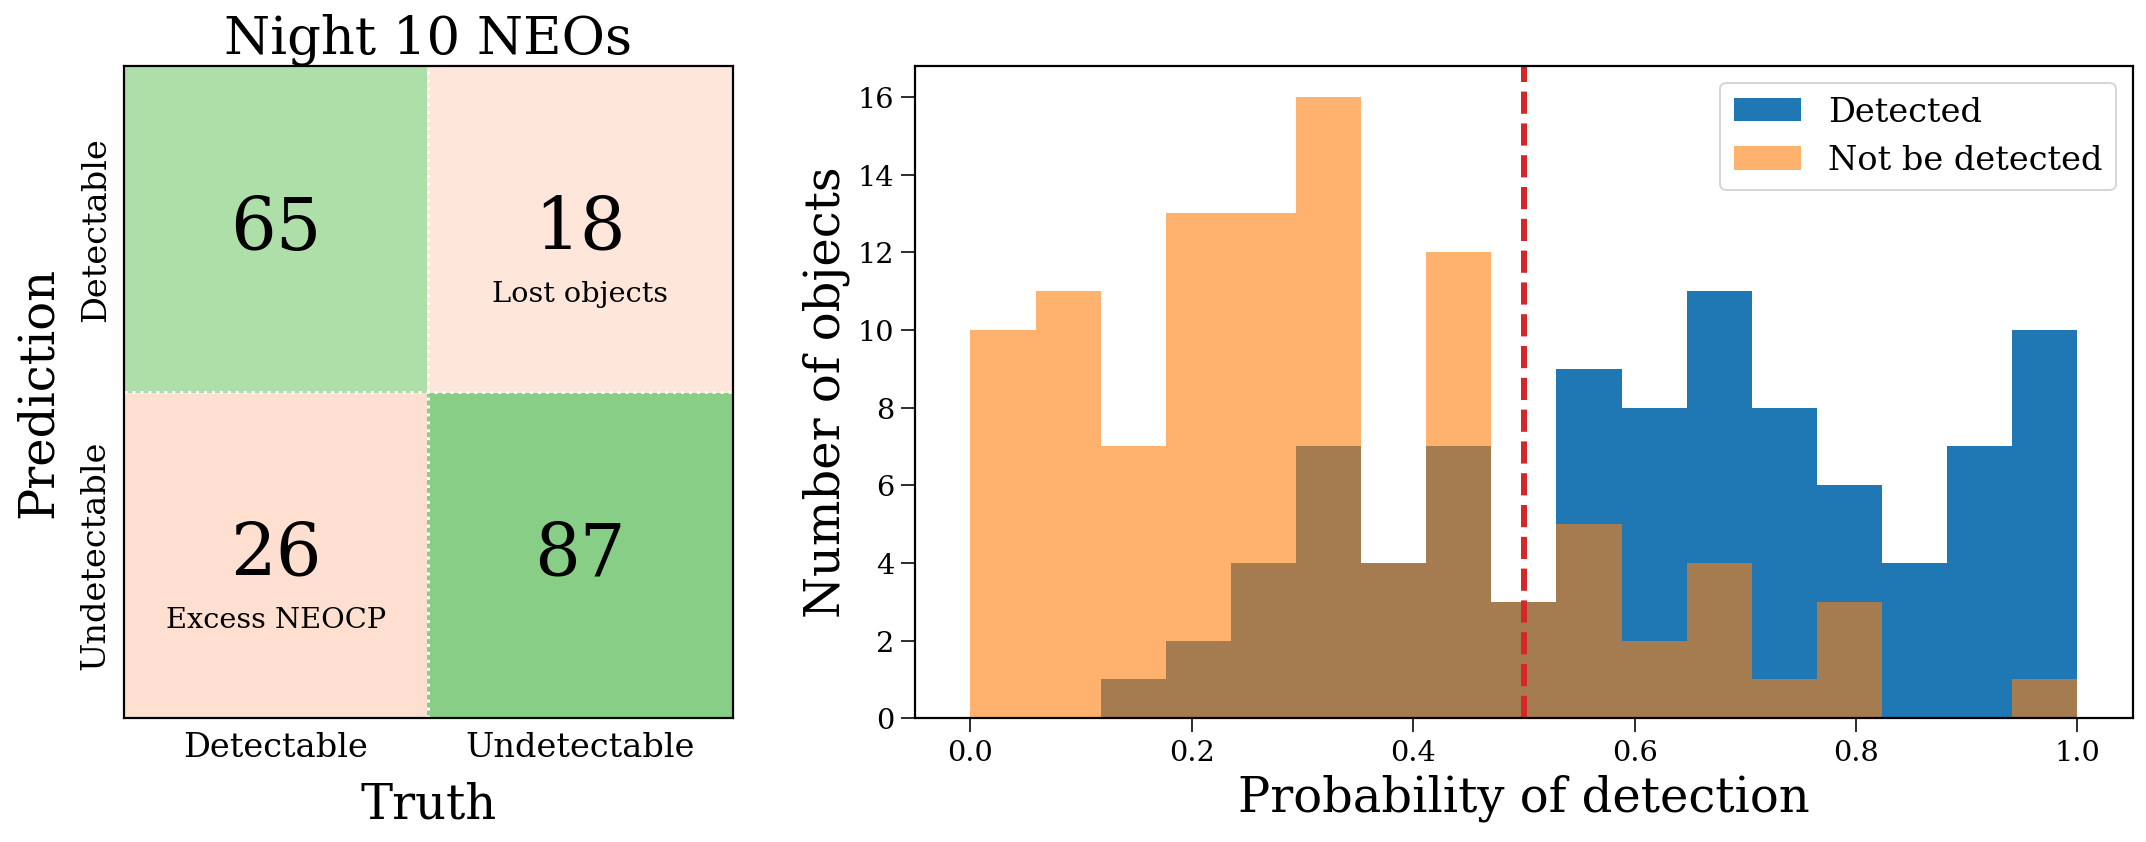

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 2]})

axes[0].set_title(f"Night {night_start} NEOs", fontsize=1.1*fs)

axes[0].axvline(0.5, color="white", linestyle="dotted")
axes[0].axhline(0.5, color="white", linestyle="dotted")

axes[0].annotate("Detectable", xy=(0.25, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)
axes[0].annotate("Undetectable", xy=(0.75, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)

axes[0].annotate("Undetectable", xy=(-0.02, 0.25), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)
axes[0].annotate("Detectable", xy=(-0.02, 0.75), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)

axes[0].annotate(incorrect_undetectable, xy=(0.25, 0.25), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate("Excess NEOCP", xy=(0.25, 0.15), ha="center", va="center", fontsize=0.6*fs)
axes[0].annotate(correct_undetectable, xy=(0.75, 0.25), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate(incorrect_detectable, xy=(0.75, 0.75), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate("Lost objects", xy=(0.75, 0.65), ha="center", va="center", fontsize=0.6*fs)
axes[0].annotate(correct_detectable, xy=(0.25, 0.75), ha="center", va="center", fontsize=1.5*fs)

axes[0].axvspan(0, 0.5, 0, 0.5, color=plt.cm.Reds(incorrect_undetectable / len(probs)))
axes[0].axvspan(0.5, 1, 0, 0.5, color=plt.cm.Greens(correct_undetectable / len(probs)))
axes[0].axvspan(0, 0.5, 0.5, 1, color=plt.cm.Greens(correct_detectable / len(probs)))
axes[0].axvspan(0.5, 1, 0.5, 1, color=plt.cm.Reds(incorrect_detectable / len(probs)))

axes[0].set_xlabel("\nTruth")
axes[0].set_ylabel("Prediction\n")

axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

bins = np.linspace(0, 1, 18)
axes[1].hist(probs[will_be_detected], label="Detected", bins=bins)
axes[1].hist(probs[np.logical_not(will_be_detected)], alpha=0.6, label="Not be detected", bins=bins)
axes[1].axvline(threshold, color="tab:red", linestyle="--", lw=3)

axes[1].set_xlabel("Probability of detection")
axes[1].set_ylabel("Number of objects")
axes[1].legend(fontsize=0.7*fs)

plt.show()

### okay let's investigate some wrong ones

In [43]:
unique_objs[np.logical_and(probs < 0.3, will_be_detected)]

Index(['00022F2', '0035981', '0009CC0', '000C2E2', '000F110', '0011372',
       '0016AFE', '001850E'],
      dtype='object', name='hex_id')

In [44]:
unique_objs[np.logical_and(probs >= 0.65, np.logical_not(will_be_detected))]

Index(['00000A7', '0001841', '00015B6', '000506E', '002A649', '003382A',
       '000A1EE', '0015C63'],
      dtype='object', name='hex_id')

In [129]:
import variant_orbits
import scheduling
import detection_probability
import magnitudes
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [46]:
s3m_cart = pd.read_hdf("../catalogues/s3m_cart.h5")
s3m_cart["hex_id"] = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m_cart.index.values))])

In [90]:
hex_id = "000296A"

In [133]:
bright_enough[bright_enough]

0         True
1         True
2         True
3         True
4         True
          ... 
378852    True
378853    True
378890    True
378891    True
378930    True
Length: 162443, dtype: bool

In [128]:
prob

0.3350993377483444

In [131]:
prob

0.34610303830911493

In [130]:
%%time
prob, joined_table = detection_probability.probability_from_id(hex_id, sorted_obs,
                                                 np.logspace(-1, 1, 51) * u.AU,
                                                 np.linspace(-100, 100, 21) * u.km / u.s,
                                                 first_visit_times, full_schedule,
                                                 night_lengths, night_list)

CPU times: user 53.3 s, sys: 13.1 s, total: 1min 6s
Wall time: 1min 13s


In [92]:
%%time
reachable_schedule = detection_probability.get_reachable_schedule(sorted_obs.loc[hex_id], first_visit_times,
                                                                  night_list, night_lengths, full_schedule)

CPU times: user 231 ms, sys: 4.94 s, total: 5.17 s
Wall time: 6.02 s


In [93]:
%%time
ephemerides, truth = detection_probability.first_last_pos_from_id(hex_id, sorted_obs, s3m_cart,
                                                             np.logspace(-1, 1, 51) * u.AU,
                                                             np.linspace(-100, 100, 21) * u.km / u.s,
                                                             first_visit_times, last_visit_times)

CPU times: user 1.33 s, sys: 10.6 s, total: 12 s
Wall time: 14.4 s


In [94]:
reload(detection_probability)
interact(detection_probability.plot_LSST_schedule_with_orbits,
         schedule=fixed(full_schedule), reachable_schedule=fixed(reachable_schedule),
         ephemerides=fixed(ephemerides), truth=fixed(truth), joined_table=fixed(joined_table),
         night=widgets.IntSlider(min=10, max=24, step=1, value=10, continuous_update=False),
         hex_id=fixed(hex_id),
         colour_by=widgets.Dropdown(
            value='distance',
            options=['distance', 'orbit'],
            description='Colour by:',
            ensure_option=True,
            disabled=False),
         lims=widgets.Dropdown(
            value='full_schedule',
            options=['orbits', 'full_schedule', 'schedule', 'reachable'],
            description='Axes limits:',
            ensure_option=True,
            disabled=False),
         filter_mask=widgets.Dropdown(
            value='all',
            options=['all', 'u', 'g', 'r', 'i', 'z', 'y'],
            description='Filter:',
            ensure_option=True,
            disabled=False),
         field_radius=fixed(2.1),
         s=widgets.IntSlider(min=1, max=25, step=1, value=15, continuous_update=False),
         show_mag_labels=widgets.ToggleButton(
            value=False,
            description='Show mag lims',
            disabled=False,
            button_style='success', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Whether to show limiting magnitudes for each field',
            icon='check'),
         fig=fixed(None), ax=fixed(None),show=fixed(True), cbar=fixed(True), ax_labels=fixed(True)
        )

interactive(children=(IntSlider(value=10, continuous_update=False, description='night', max=24, min=10), Dropd…

<function detection_probability.plot_LSST_schedule_with_orbits(schedule, reachable_schedule, ephemerides, joined_table, truth, night, hex_id, colour_by='distance', lims='full_schedule', field_radius=2.1, s=10, filter_mask='all', show_mag_labels=False, fig=None, ax=None, show=True, ax_labels=True, cbar=True)>

# Are particular orbits harder to predict (I guess yes)

Update: I guessed wrong

In [50]:
import thor

In [48]:
true_params = s3m_cart[np.isin(s3m_cart["hex_id"], unique_objs)]

In [51]:
orbits_class = thor.Orbits(orbits=np.atleast_2d(np.concatenate(([true_params["x"], true_params["y"], true_params["z"]],
                                                                [true_params["vx"], true_params["vy"], true_params["vz"]]))).T,
                           epochs=Time(true_params["t_0"], format="mjd"))

In [52]:
orbits_class.keplerian = thor.kepler.convertOrbitalElements(orbits_class.cartesian,
                                                            "cartesian", "keplerian")

In [53]:
q = orbits_class.keplerian[:, 0] * (1 - orbits_class.keplerian[:, 1])

In [54]:
got_it_right = (probs > 0.5) == will_be_detected

In [55]:
colours = ["tab:green" if yup else "tab:red" for yup in got_it_right]

In [56]:
true_params

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S000002Ma,167.0,-1.667047,-0.858776,-1.326359,0.004811,-0.005856,-0.004398,1.0,54466.0,3.0,15.849,0.15,00000A7
S000005Aa,335.0,-2.670562,-0.879820,-1.468497,0.004954,-0.002611,-0.002842,1.0,54466.0,3.0,16.713,0.15,000014F
S000009Ea,579.0,-2.034149,-0.117710,-0.933631,-0.000217,-0.007789,0.001225,1.0,54466.0,3.0,17.390,0.15,0000243
S00000fua,932.0,-0.816946,3.114705,-0.379257,-0.006347,0.001696,-0.000940,1.0,54466.0,3.0,17.977,0.15,00003A4
S00000jsa,1175.0,-1.428541,-0.739073,-1.059737,0.010892,-0.002073,0.003008,1.0,54466.0,3.0,18.259,0.15,0000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00015ySa,252642.0,-1.241447,0.363831,-0.070625,-0.000347,-0.015706,-0.002807,1.0,54466.0,3.0,24.924,0.15,003DAE2
S00015RKa,253781.0,2.664565,-1.647325,0.364562,0.003198,0.006329,-0.000184,1.0,54466.0,3.0,24.930,0.15,003DF55
S00017xaa,260048.0,-1.120751,-0.151135,-0.043414,0.002398,-0.016566,0.007642,1.0,54466.0,3.0,24.960,0.15,003F7D0
S0001805a,261795.0,0.300718,0.449375,0.254915,-0.025643,0.013277,0.002702,1.0,54466.0,3.0,24.968,0.15,003FEA3


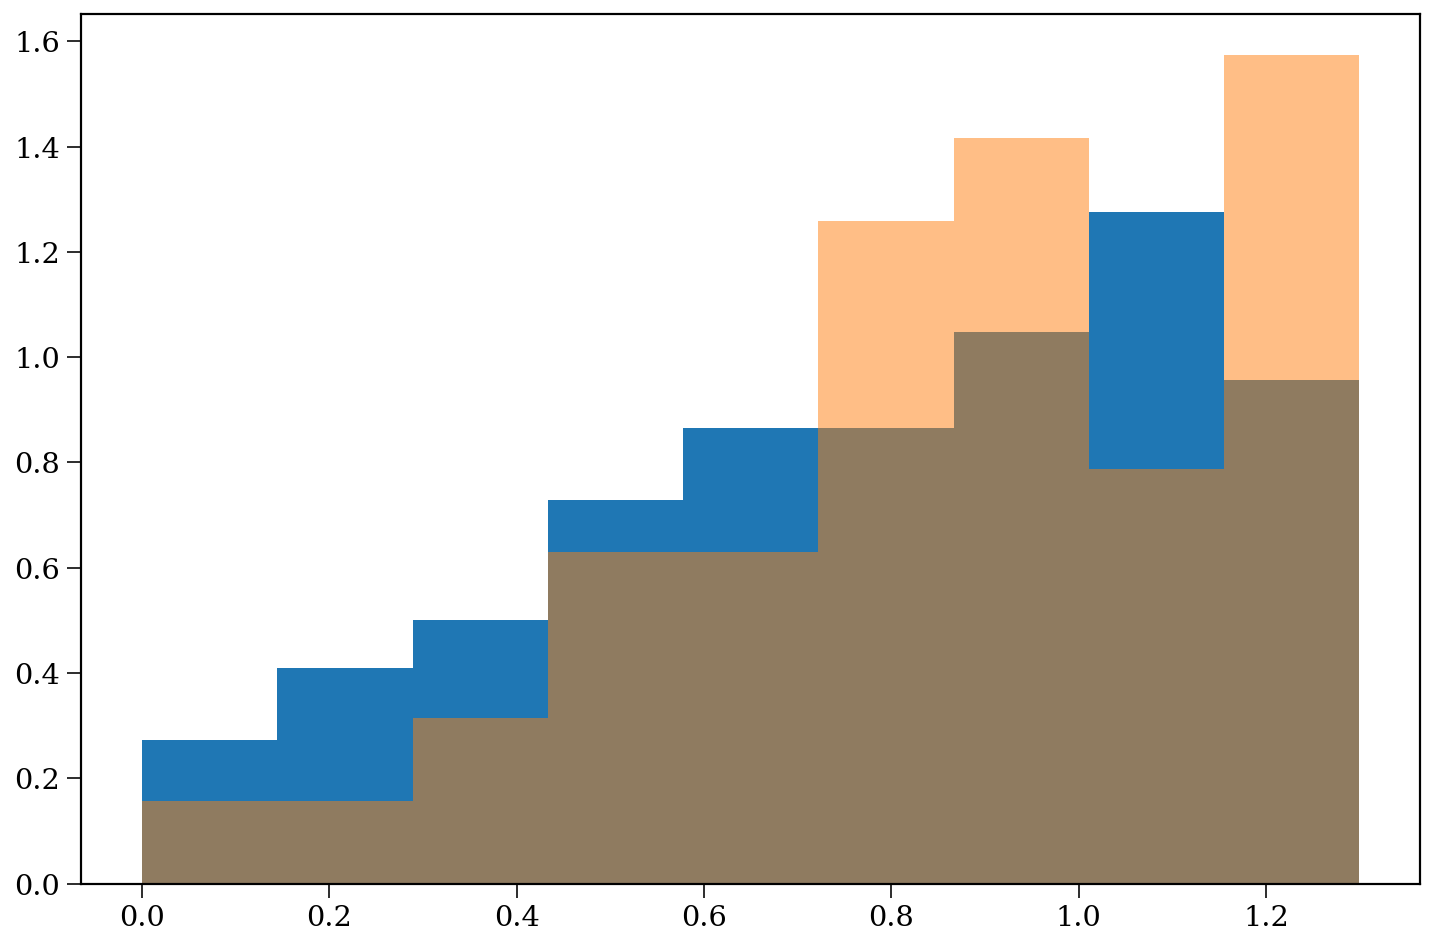

In [64]:
plt.hist(q[got_it_right], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False)
plt.hist(q[np.logical_not(got_it_right)], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False, alpha=0.5)
plt.show()

In [78]:
sc = SkyCoord(x=true_params["x"] * u.AU, y=true_params["y"] * u.AU, z=true_params["z"] * u.AU,
         v_x=true_params["vx"] * u.AU / u.day, v_y=true_params["vy"] * u.AU / u.day, v_z=true_params["vz"] * u.AU / u.day,
         frame="heliocentriceclipticiau76", representation_type="cartesian")

In [80]:
sc.transform_to("icrs").dec

<Latitude [-4.26195977e+01, -3.22914713e+01, -2.37231747e+01,
            1.59378369e+01, -4.09777900e+01,  3.78583545e+01,
           -1.06836469e+01, -2.98440073e+01,  5.16319752e-01,
           -3.87691675e+01, -3.50857780e+00,  3.82140340e+00,
           -5.20693997e+00, -3.95406799e+01,  4.33931175e+01,
           -9.75720779e+00, -5.21721060e+01, -5.89266611e+01,
           -2.24026068e+01, -4.80962996e+01, -2.81064499e+01,
            2.93205129e+01,  2.22192286e+01,  2.45959909e+00,
           -1.39388002e+01,  3.78021236e+01, -7.45805364e+00,
           -1.11743370e+00, -4.19530486e+01, -4.92075884e+01,
           -5.41168944e+01,  3.54369955e+00, -1.97183381e+01,
            2.78456311e+01, -2.73656530e+01,  1.96673108e+01,
            2.10235692e+01,  1.14507319e+01, -3.18970816e+01,
           -1.33822790e+01,  2.04241291e+01, -2.48786846e+01,
           -4.52631713e+00,  3.23004632e+01, -2.09499206e+01,
           -2.33388521e+01,  1.84905706e+01,  1.88503133e+01,
        

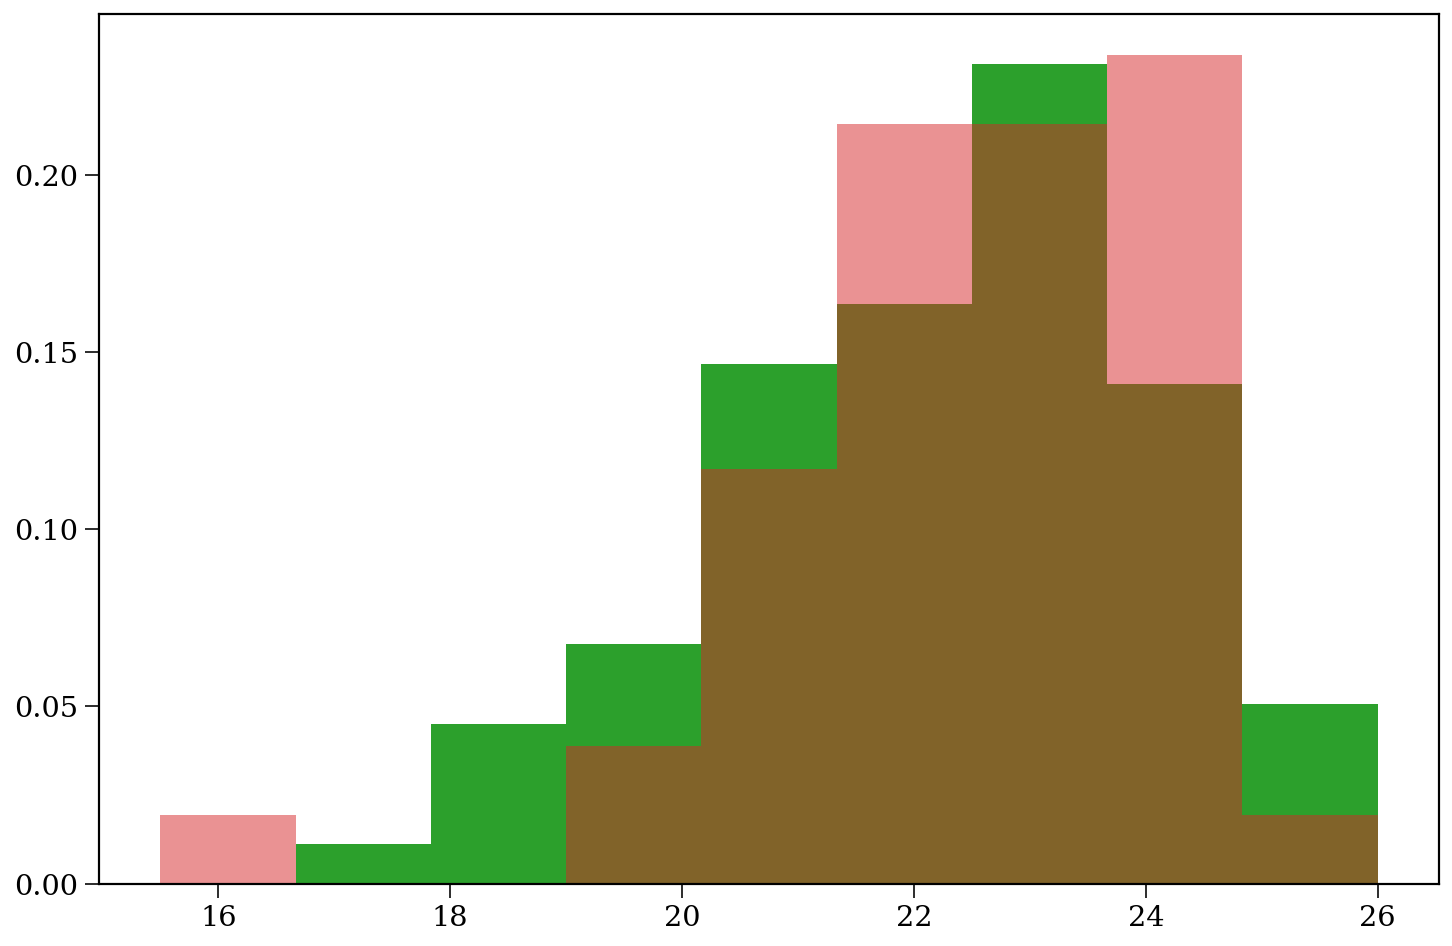

In [66]:
plt.hist(true_params["H"][got_it_right], density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:green")
plt.hist(true_params["H"][np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:red")
plt.show()

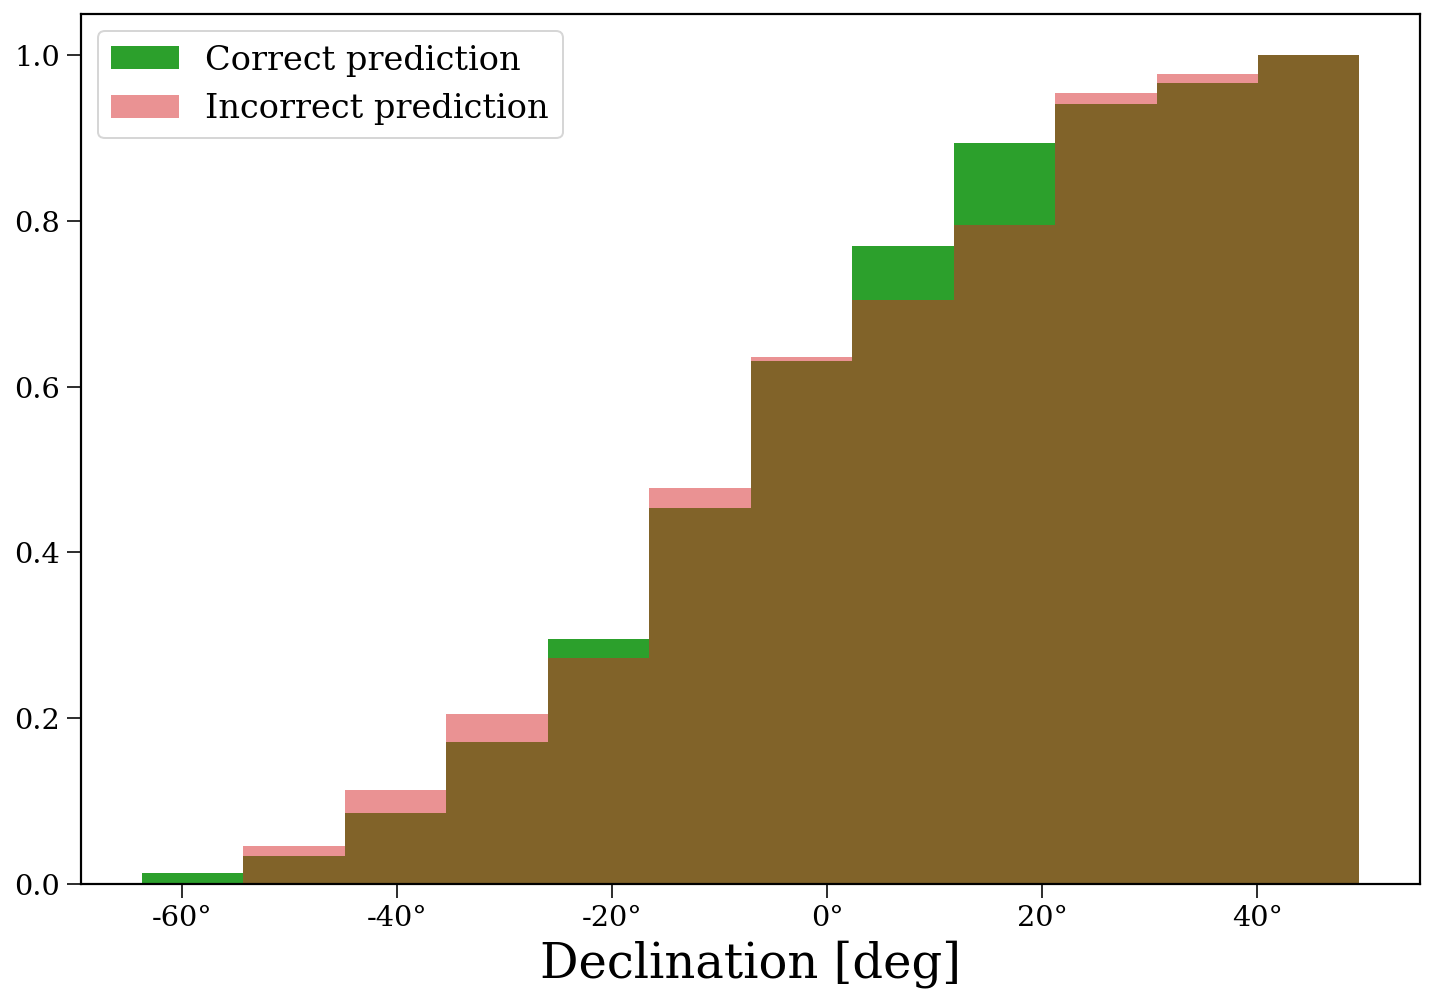

In [89]:
bins = np.linspace(min(sc.transform_to("icrs").dec), max(sc.transform_to("icrs").dec), 13)

plt.hist(sc.transform_to("icrs").dec[got_it_right], density=True, cumulative=True, bins=bins, color="tab:green", label="Correct prediction")
plt.hist(sc.transform_to("icrs").dec[np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=True, bins=bins, color="tab:red", label="Incorrect prediction")

plt.legend(fontsize=0.7*fs)

plt.xlabel("Declination [deg]")

plt.show()

# Probability of each predicted detection based on orbit fraction

In [229]:
for i in range(10, 25):
    x = joined_table[joined_table["observed"] & (joined_table["night"] == i)]
    print(i)
    print(x.groupby("mjd_utc").count()["orbit_id"] / len(joined_table["orbit_id"].unique()) * 100)
    print()

10
mjd_utc
59649.295709    100.0
59649.296156    100.0
59649.320180    100.0
59649.320627    100.0
Name: orbit_id, dtype: float64

11
mjd_utc
59650.330174    100.000000
59650.351728     99.543379
Name: orbit_id, dtype: float64

12
mjd_utc
59651.250333    1.065449
59651.274791    0.913242
Name: orbit_id, dtype: float64

13
mjd_utc
59652.367719    77.625571
59652.376183     0.456621
59652.377078     6.392694
59652.378861    36.834094
59652.387323     0.608828
59652.388219     6.392694
Name: orbit_id, dtype: float64

14
mjd_utc
59653.244888    1.065449
59653.247818    3.500761
59653.268607    1.065449
59653.271480    3.348554
Name: orbit_id, dtype: float64

15
mjd_utc
59654.240757    8.980213
59654.241222    3.500761
59654.241678    0.608828
59654.242138    1.369863
59654.264676    9.132420
59654.265141    3.500761
59654.265598    0.608828
59654.266058    1.522070
Name: orbit_id, dtype: float64

16
mjd_utc
59655.262812     1.674277
59655.263260     2.435312
59655.263715    26.940639
59655

In [205]:
x = joined_table[joined_table["observed"] & (joined_table["night"] == 18)]
x.groupby("mjd_utc").count()["orbit_id"].values / len(joined_table["orbit_id"].unique()) * 100

array([ 0.15384615,  0.76923077, 36.        , 26.30769231,  8.30769231,
       19.38461538, 10.15384615,  2.61538462,  0.15384615,  0.76923077,
       36.30769231, 26.30769231,  8.30769231, 19.53846154, 10.30769231,
        2.46153846,  0.15384615,  0.76923077, 36.        , 26.30769231,
        8.        , 19.53846154, 10.46153846,  2.46153846,  0.15384615,
        0.76923077, 35.84615385, 26.30769231,  8.        , 19.38461538,
       10.76923077,  2.46153846,  0.76923077, 26.30769231,  8.        ,
       19.23076923, 35.84615385,  0.15384615,  0.76923077, 26.15384615,
        8.        , 19.38461538, 35.69230769,  0.15384615,  0.15384615,
        0.76923077, 35.69230769, 26.15384615,  0.15384615,  1.69230769,
       19.69230769, 10.61538462,  2.30769231,  0.15384615,  0.76923077,
       35.53846154, 26.15384615,  0.15384615,  1.84615385, 19.38461538,
       10.61538462,  2.30769231])